<a href="https://colab.research.google.com/github/anosharahim/capstone/blob/master/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Import Packages and Libraries

In [1]:
#for preprocessing
import pandas as pd
import os
import imageio
import numpy as np
import random 

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

#machine learning specific 
import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#get GPU
#K.tensorflow_backend._get_available_gpus()

# Load and Preprocess Image Data

In [3]:
train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

train_data = []
train_label = []
test_data = []
test_label = []

num_expressions = 6

#keep track of y labels 
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_image_arrays(folder_path, label_dict):
  data = []
  label = []
  freq = {}

  for category in os.listdir(folder_path): 

    category_name = label_dict[category]
    category_path = folder_path + category + '/'
    freq[category] = 0

    for image in os.listdir(category_path):
      image_file = category_path + image 
      image_array = imageio.imread(image_file) #get image array from file 
      #image_array.resize((32, 32))
      image_array = np.array(image_array) #convert to numpy array 
      #add image array and it's label to respective folders 
      data.append(image_array)
      label.append(category_name)
      freq[category] += 1

  data = np.array(data)
  label = np.array(label)

  data, label = unison_shuffled_copies(data, label)

  return data, label, freq

train_data, train_label, train_freq = get_image_arrays(train_path, emotion_dictionary)
test_data, test_label, test_freq = get_image_arrays(test_path, emotion_dictionary)

#save numpy arrays for future use 
np.savez('/content/drive/MyDrive/Capstone/datasets/train.npz',train_data, train_label)
np.savez('/content/drive/MyDrive/Capstone/datasets/test.npz',test_data, test_label)


In [4]:
#load data from gdrive
train_npz = np.load("/content/drive/MyDrive/Capstone/datasets/train.npz")
test_npz = np.load("/content/drive/MyDrive/Capstone/datasets/test.npz")


x_train = train_npz["arr_0"]
y_train = train_npz["arr_1"]
x_test = test_npz["arr_0"]
y_test = test_npz["arr_1"]

print('Train Size: ', x_train.shape, y_train.shape)
print('Test Size: ',x_test.shape, y_test.shape)

Train Size:  (28709, 48, 48) (28709,)
Test Size:  (7178, 48, 48) (7178,)


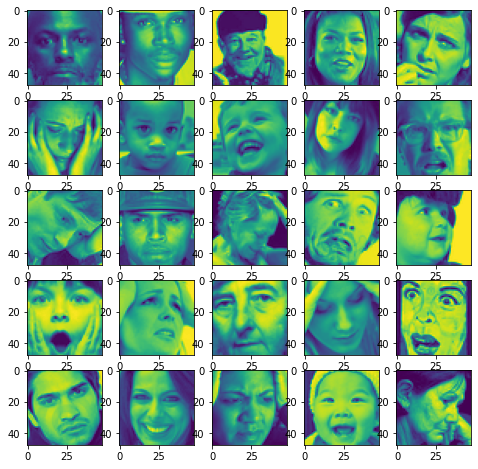

In [7]:
#visualize random samples
fig, axes = plt.subplots(5,5, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[random.randint(0,len(x_train))])

Text(0.5, 1.0, 'Emotion Class Distribution in Training Data')

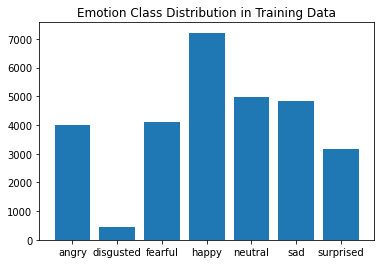

In [8]:
#visualize class distribution
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}
values, counts = np.unique(y_train, return_counts=True)
class_dist = {}
for i in range(len(values)):
  class_dist[i] = counts[i]

plt.bar(emotion_dictionary.keys(),class_dist.values())
plt.title("Emotion Class Distribution in Training Data")

<BarContainer object of 7 artists>

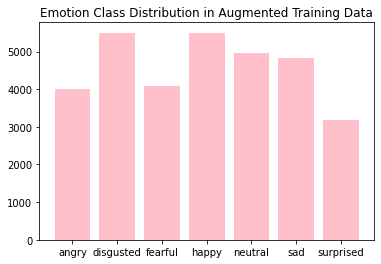

In [10]:
#randomly undersample majority class -- happiness 
class_undersample =  {0: 3995, 1: 436, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
x_train_reshape = x_train.reshape(len(x_train),48*48)
undersample = RandomUnderSampler(sampling_strategy=class_undersample)
x_train_under, y_train_under = undersample.fit_resample(x_train_reshape,y_train)

#oversample minority class - disgust - using k-nearest data augmentation
class_oversample =  {0: 3995, 1: 3500, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
sm = SMOTE(sampling_strategy='minority', random_state=42)
x_train, y_train = sm.fit_resample(x_train_under,y_train_under)

#visualize new distribution 
values, counts_ = np.unique(y_train, return_counts=True)
plt.title("Emotion Class Distribution in Augmented Training Data")
plt.bar(emotion_dictionary.keys(),counts_, color = 'pink')

In [11]:
#add 2 more channels to grayscale image to imitate rgb
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)


#split test set into validation and test set 
x_val, x_test, y_val ,y_test = train_test_split(x_test,y_test, test_size=0.3)

x_train = np.resize(x_train, (len(x_train), 32,32,3))
x_val = np.resize(x_val, (len(x_val), 32,32,3))
x_test = np.resize(x_test, (len(x_test), 32,32,3))

print('Train -- ', x_train.shape, y_train.shape)
print('Val -- ', x_val.shape, y_val.shape)
print('Test -- ', x_test.shape, y_test.shape)


Train --  (32058, 32, 32, 3) (32058,)
Val --  (5024, 32, 32, 3) (5024,)
Test --  (2154, 32, 32, 3) (2154,)


In [ ]:
input_t = K.Input(shape=(32,32,3))
res50_model = K.applications.ResNet50(include_top=False, weights="imagenet",input_tensor=input_t)

#freeze the first n layers 
freeze_layers = 145
#only train last 30 layers 
for layer in res50_model.layers[:freeze_layers]:
  layer.trainable =False

#verify that the desired layers are frozen 
for i, layer in enumerate(res50_model.layers):
  if i == 10:
    print("...")
  if i < 10 or i > (freeze_layers - 3):  
    print(i,layer.name,'-',layer.trainable)

#add further layers 
model = K.models.Sequential()
model.add(res50_model)
#model.add(K.layers.Dropout(0.6))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(10, activation='softmax'))

'''
model.add(res50_model)
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dense(7,activation='softmax'))
-----

model.add(res50_model)
#model.add(K.layers.BatchNormalization())
#model.add(K.layers.GlobalAveragePooling2D())
model.add(K.layers.Flatten()) 
model.add(K.layers.Dropout(0.6)) #to avoid overfitting 
model.add(K.layers.Dense(10, activation='softmax'))
'''

#Compile the model 
#since y labels are integers, use sparse categorical cross-entropy 
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=K.optimizers.Adam(learning_rate=2e-5),#Adam(learning_rate=2e-5),
                  metrics=['accuracy'])

model.summary()

0 input_32 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
...
143 conv5_block1_1_conv - False
144 conv5_block1_1_bn - False
145 conv5_block1_1_relu - True
146 conv5_block1_2_conv - True
147 conv5_block1_2_bn - True
148 conv5_block1_2_relu - True
149 conv5_block1_0_conv - True
150 conv5_block1_3_conv - True
151 conv5_block1_0_bn - True
152 conv5_block1_3_bn - True
153 conv5_block1_add - True
154 conv5_block1_out - True
155 conv5_block2_1_conv - True
156 conv5_block2_1_bn - True
157 conv5_block2_1_relu - True
158 conv5_block2_2_conv - True
159 conv5_block2_2_bn - True
160 conv5_block2_2_relu - True
161 conv5_block2_3_conv - True
162 conv5_block2_3_bn - True
163 conv5_block2_add - True
164 conv5_block2_out - True
165 conv5_block3_1_conv - True
166 conv5_block3_1_bn - True
167 conv5_block3_1_relu - True
168 conv5_block3_2

In [ ]:
ckpt_path = os.path.join('/gdrive', 'ckpt', 'fer_2013') 

#create model checkpoint to save weights
check_point = K.callbacks.ModelCheckpoint(filepath=  ckpt_path,
                                              monitor="val_accuracy",
                                              mode="max",
                                              save_best_only=True,)

#Train the model 
history = model.fit(X_train, y_train, batch_size=512,  epochs=25, verbose=1, #batch_size=512,
                        validation_data=(X_val, y_val),
                        callbacks=[check_point])

model.save(ckpt_path) 

Epoch 1/25
 5/57 [=>............................] - ETA: 13:37 - loss: 3.2955 - accuracy: 0.1070

KeyboardInterrupt: ignored

In [ ]:
## add dropout layers for combatting overfitting 
## freeze most of the early layers of resnet
## use a batch-normalization layer for bigger batch sizes
## hyperparameter tuning 

## huge difference in validation and train accuracy observed at 512 batches for 5 epochs with minor improvements in validation accuracy 
## L2 regularization

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


[0.122748963534832,
 0.21906022727489471,
 0.2880629897117615,
 0.3571353852748871,
 0.42481452226638794]

# PCA: Principal Component Analysis

In [17]:
x_train.shape

(32058, 32, 32, 3)

In [16]:
#rescaling data between 0 and 1 
scaler = MinMaxScaler()
#train_rescaled = scaler.fit_transform(x_train.reshape(len(x_train),32*32))

#Two-Component PCA
pca_ = PCA(n_components=2)
pca_ = pca_.fit_transform(x_train)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)

plt.scatter(pca_[:, 0], pca_[:, 1], s = 1, cmap = c_map , c = y_train) 
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.title('Figure 1. ')
plt.show()


ValueError: ignored

NameError: ignored

In [ ]:

#Three-Component PCA
pca_3d = PCA(n_components=3)
pca_3d = pca_3d.fit_transform(train_rescaled)

#plot 3 components 

def plot_3d(component1,component2,component3):
    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=2,
            color=x_train,      # set color to an array/list of desired values
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1
        )
    )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
    fig.layout.template = 'plotly_white'
    fig.show()

plt.ioff()
plot_3d(pca_3d[:, 0],pca_3d[:, 1],pca_3d[:, 2])

In [ ]:
#rescaling data between 0 and 1 
scaler = MinMaxScaler()
train_rescaled = scaler.fit_transform(train_data.reshape(len(train_data),48*48))

#PCA that explains 95% of the variance in data 
_pca = PCA(n_components = 0.95) 
_pca.fit(train_rescaled)
reduced = _pca.transform(train_rescaled)
print(train_rescaled.shape, reduced.shape) 

# TSNE: T-distributed Stochastic Neighbor Embedding (T-SNE)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



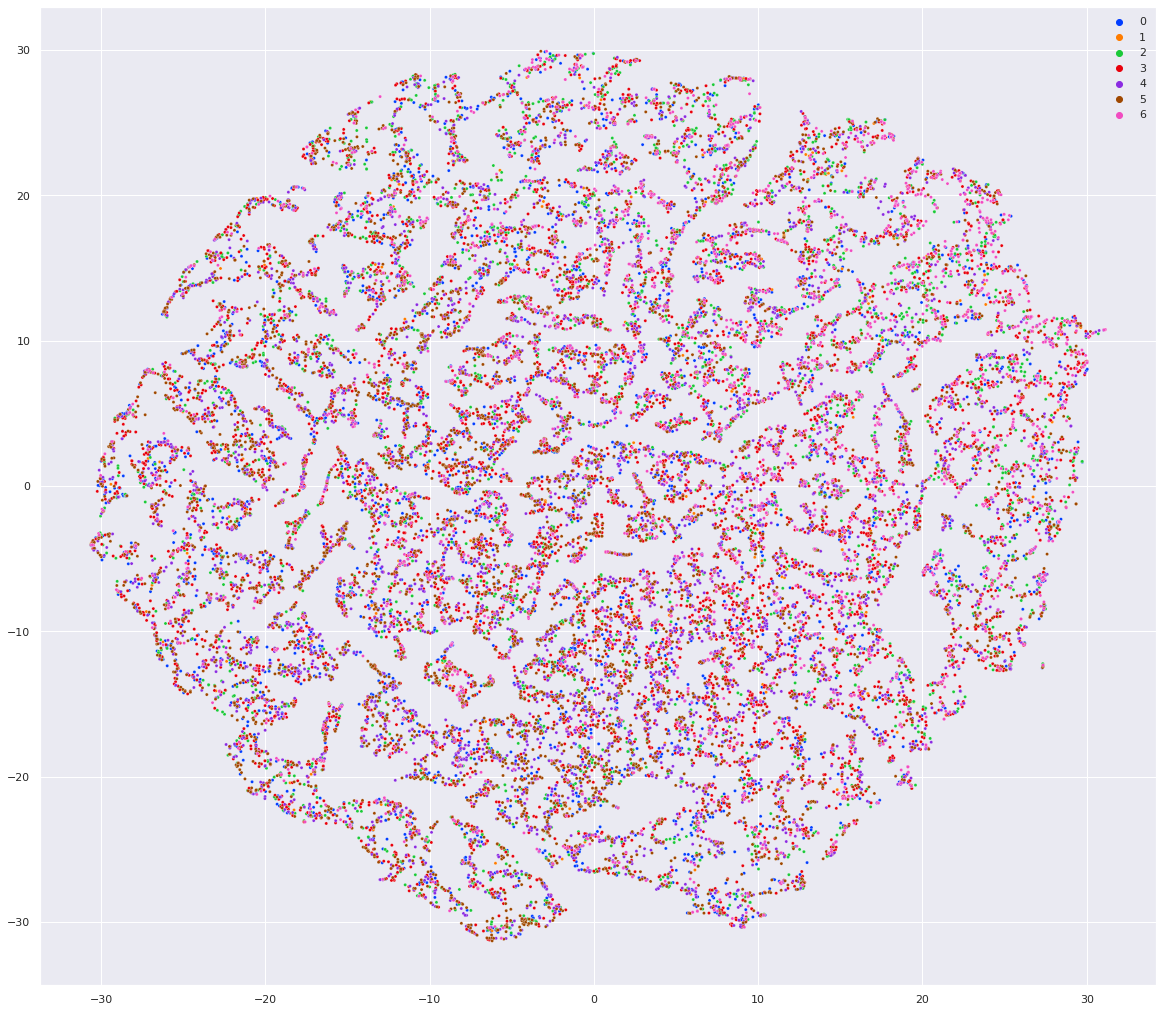

In [ ]:
tsne = TSNE(learning_rate=20)
TSNE_features = tsne.fit_transform(pca_3d)
a = TSNE_features[:,0]
b = TSNE_features[:,1]
sns.scatterplot(a,b,hue=train_label, legend='full',s=10, palette = 'bright')#, hue=y, legend='full')
sns.set(rc={'figure.figsize':(20,18)})

# UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction

Text(0.5, 1.0, 'UMAP projection of FER2013 dataset')

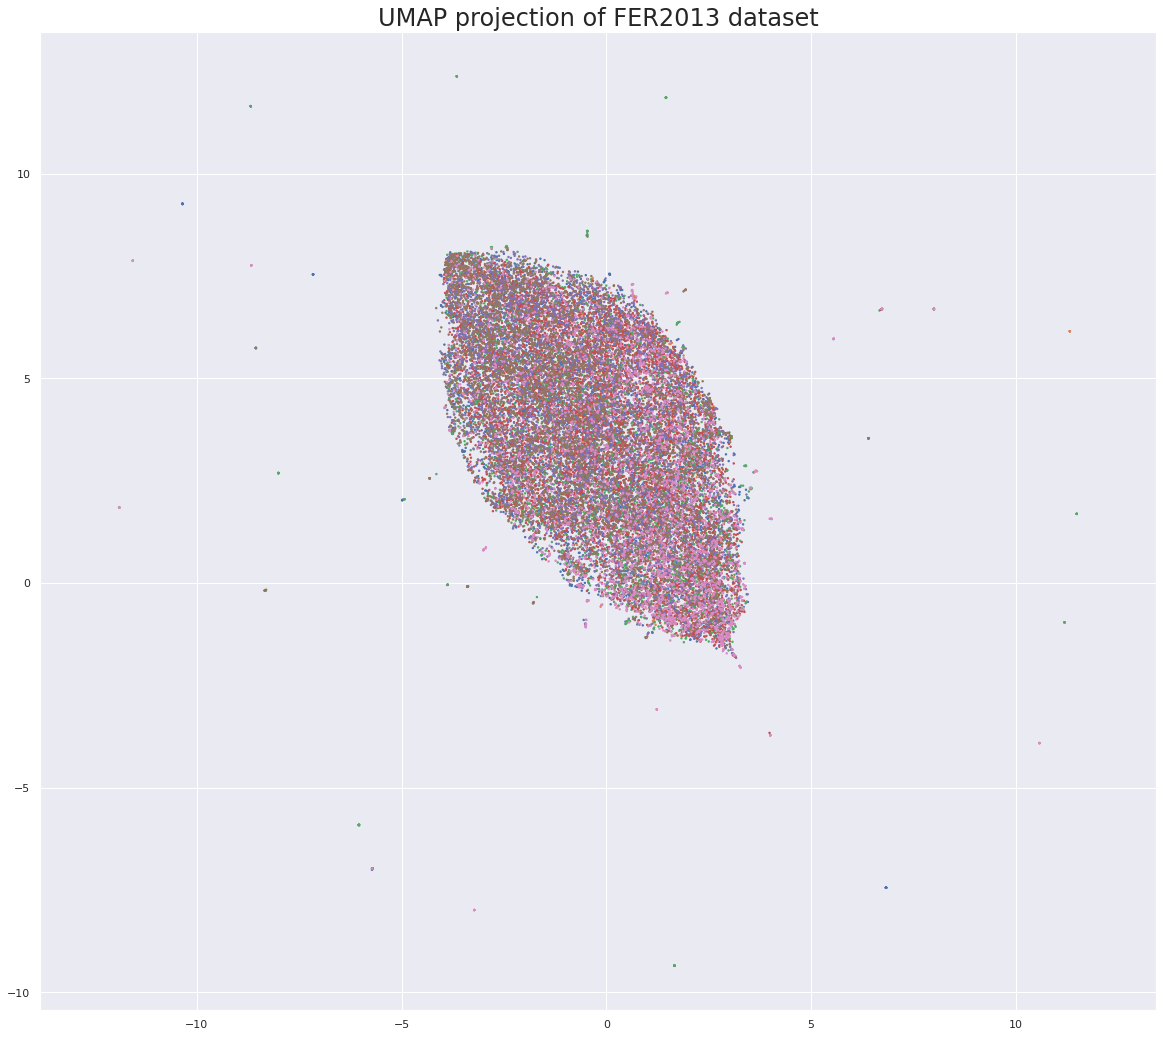

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(train_rescaled)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in train_label], s= 2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of FER2013 dataset', fontsize=24)